# **Housing Prices Competition**
* **Regressor Algorithm Used:** XGBoost
* **Hyper-parameters optimized:** learning_rate, n_estimators, max_depth, subsample, gamma, colsample (using RandomizedSearchCV)
* Used 'pipelines' to improve the efficiency of machine learning code.

## Contents:
1. **X, y Dataframes Creation**
2. **X, y Summary**
3. **Data Cleaning**
4. **Feature Engineering**
5. **Feature Selection**
6. **Model Creation**
7. **Training and Testing Model**

# 1) X, y Dataframes Creation

## Import Libraries

In [1]:
# Data Analytics Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype

In [2]:
# Machine Learning Libraries
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

## List all files under the input directory

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


## Read the data

In [4]:
Xy = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv', index_col='Id')
X_test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv', index_col='Id')

## Separate target from predictors

In [5]:
# First remove rows with missing target
Xy = Xy.dropna(axis=0, subset=['SalePrice'])

X = Xy.drop(['SalePrice'], axis=1)
y = Xy.SalePrice

# 2) X, y Summary

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [7]:
X.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

In [8]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

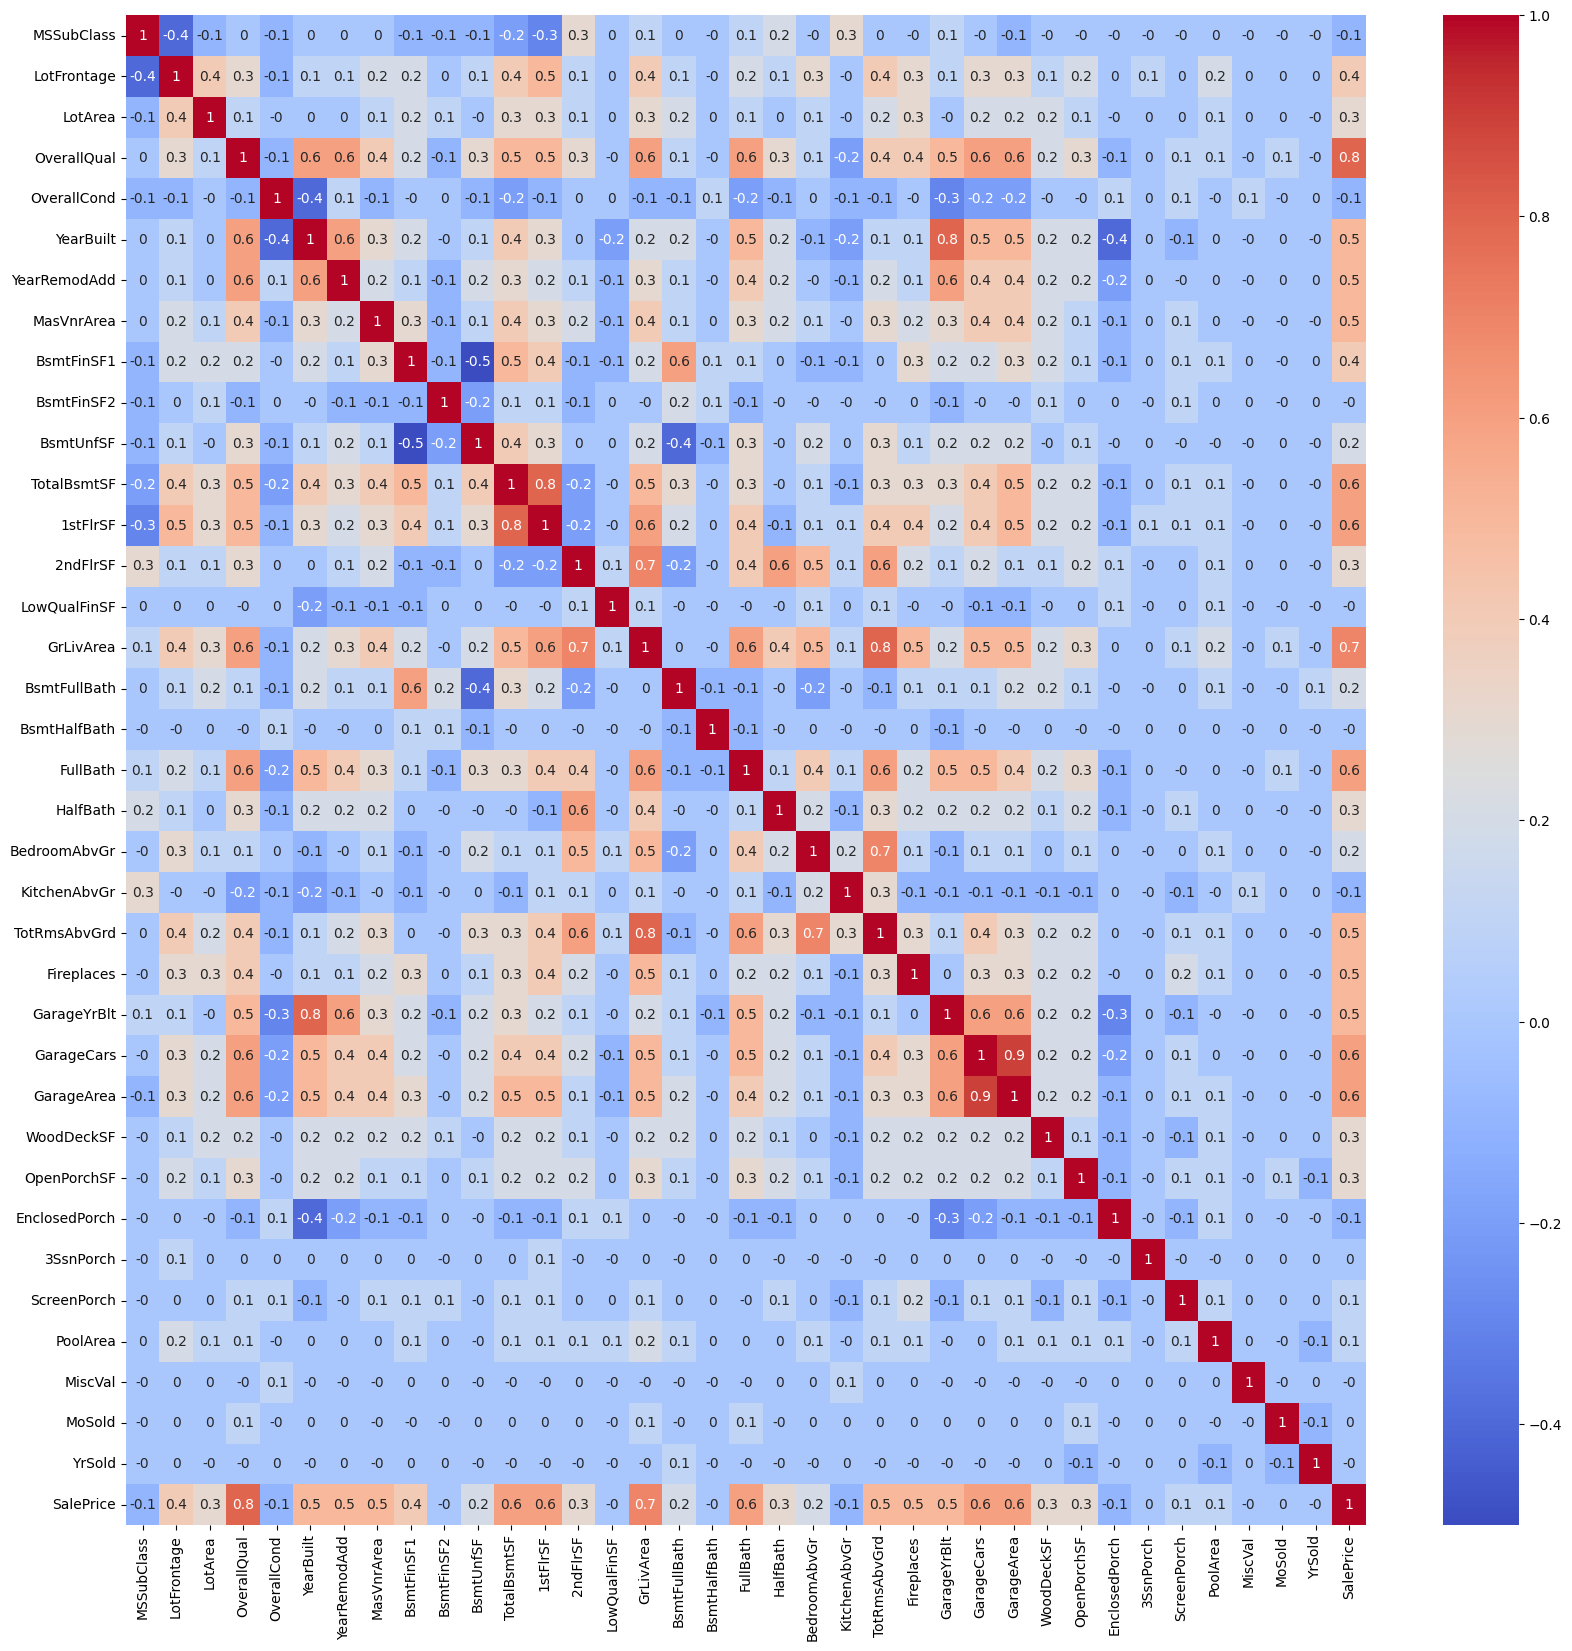

In [9]:
plt.figure(figsize = (20,20),dpi=100)
sns.heatmap(round(Xy.corr(),1),cmap='coolwarm',annot=True)
plt.show()

# 3) Data Cleaning

## Remove the columns with more than half missing values

In [10]:
null_values = X.isnull().sum()
null_values[null_values>0].sort_values()

Electrical         1
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtExposure      38
BsmtFinType2      38
GarageCond        81
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
LotFrontage      259
FireplaceQu      690
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64

In [11]:
null_values.sum()

6965

In [12]:
# Columns with missing values more than half of the number of rows
null_col = [col for col in X.columns if X[col].isnull().sum() > len(X)/2]
null_col

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [13]:
X.drop(null_col,axis=1,inplace=True)
X_test.drop(null_col,axis=1,inplace=True)

In [14]:
# Total null values after removing columns with more than half missing values
X.isnull().sum().sum()

1558

# 4) Feature Engineering

## 4.1) Boolean Columns

## Adding features 'Garage', 'Fireplace' and 'Bsmt'

Garage column: Boolean
* False (for 81 rows having missing values in columns GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond)
* True (for all others rows)

In [15]:
X['Garage'] = X['GarageQual'].notnull()
X_test['Garage'] = X_test['GarageQual'].notnull()

Fireplace column: Binary Categorical
* False (for 690 rows having missing values in column FireplaceQu)
* True (for all others rows)

In [16]:
X['Fireplace'] = X['FireplaceQu'].notnull()
X_test['Fireplace'] = X_test['FireplaceQu'].notnull()

Basement column: Binary Categorical
* False (for 37 rows having missing values in columns BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2)
* True (for all others rows)

In [17]:
X['Bsmt'] = X['BsmtQual'].notnull()
X_test['Bsmt'] = X_test['BsmtQual'].notnull()

In [18]:
X.dtypes.value_counts()

object     39
int64      33
float64     3
bool        3
dtype: int64

## Making boolean into numerical data

In [19]:
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols].nunique()

Garage       2
Fireplace    2
Bsmt         2
dtype: int64

In [20]:
X.loc[:,bool_cols] = X.loc[:,bool_cols].replace([False,True], [0,1])
X_test.loc[:,bool_cols] = X_test.loc[:,bool_cols].replace([False,True], [0,1])

In [21]:
X.loc[:,bool_cols].head(2)

,Garage,Fireplace,Bsmt
Id,,,
1,1,0,1
2,1,1,1


## 4.2) Ordered Categorical Columns

## Casting object datatype to ordinal datatype (i.e. ordered category)

In [22]:
object_cols = X.select_dtypes(include=['object']).columns
X[object_cols].nunique().sort_values()

Street            2
CentralAir        2
Utilities         2
GarageFinish      3
LandSlope         3
PavedDrive        3
BsmtQual          4
ExterQual         4
MasVnrType        4
KitchenQual       4
BsmtCond          4
BsmtExposure      4
LandContour       4
LotShape          4
HeatingQC         5
FireplaceQu       5
GarageQual        5
Electrical        5
GarageCond        5
LotConfig         5
ExterCond         5
BldgType          5
MSZoning          5
GarageType        6
Heating           6
Foundation        6
BsmtFinType1      6
RoofStyle         6
BsmtFinType2      6
SaleCondition     6
Functional        7
RoofMatl          8
HouseStyle        8
Condition2        8
SaleType          9
Condition1        9
Exterior1st      15
Exterior2nd      16
Neighborhood     25
dtype: int64

In [23]:
ordinal_cols = [i for i in object_cols if ('QC' in i) or ('Qu' in i) or ('Fin' in i) or ('Cond' in i) and ('Condition' not in i)]
{col:[*X[col].unique()] for col in ordinal_cols}

{'ExterQual': ['Gd', 'TA', 'Ex', 'Fa'],
 'ExterCond': ['TA', 'Gd', 'Fa', 'Po', 'Ex'],
 'BsmtQual': ['Gd', 'TA', 'Ex', nan, 'Fa'],
 'BsmtCond': ['TA', 'Gd', nan, 'Fa', 'Po'],
 'BsmtFinType1': ['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'],
 'BsmtFinType2': ['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ'],
 'HeatingQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
 'KitchenQual': ['Gd', 'TA', 'Ex', 'Fa'],
 'FireplaceQu': [nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'],
 'GarageFinish': ['RFn', 'Unf', 'Fin', nan],
 'GarageQual': ['TA', 'Fa', 'Gd', nan, 'Ex', 'Po'],
 'GarageCond': ['TA', 'Fa', nan, 'Gd', 'Po', 'Ex']}

### 1] Columns with categorical order

In [24]:
ordinal_cols1 = [i for i in ordinal_cols if ('Fin' not in i)]
print(*ordinal_cols1, sep=', ')

ExterQual, ExterCond, BsmtQual, BsmtCond, HeatingQC, KitchenQual, FireplaceQu, GarageQual, GarageCond


In [25]:
X.loc[:,ordinal_cols1] = X.loc[:,ordinal_cols1].fillna('NA')
cat_type1 = CategoricalDtype(categories=['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
X.loc[:,ordinal_cols1] = X.loc[:,ordinal_cols1].astype(cat_type1)
X_test.loc[:,ordinal_cols1] = X_test.loc[:,ordinal_cols1].astype(cat_type1)

### 2] Columns with categorical order

In [26]:
ordinal_cols2 = [i for i in ordinal_cols if ('Fin' in i)]
print(*ordinal_cols2, sep=', ')

BsmtFinType1, BsmtFinType2, GarageFinish


In [27]:
X.loc[:,ordinal_cols2] = X.loc[:,ordinal_cols2].fillna('NA')
cat_type2 = CategoricalDtype(categories=['NA', 'Unf', 'RFn', 'Fin', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ordered=True)
X.loc[:,ordinal_cols2] = X.loc[:,ordinal_cols2].astype(cat_type2)
X_test.loc[:,ordinal_cols2] = X_test.loc[:,ordinal_cols2].astype(cat_type2)

## Making ordered categories into numerical data

In [28]:
X.loc[:,ordinal_cols1] = X.loc[:,ordinal_cols1].replace(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], [0,1,2,3,4,5])
X.loc[:,ordinal_cols2] = X.loc[:,ordinal_cols2].replace(['NA', 'Unf', 'RFn', 'Fin', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], list(range(9)))

In [29]:
# Test data
X_test.loc[:,ordinal_cols1] = X_test.loc[:,ordinal_cols1].replace(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],[0,1,2,3,4,5])
X_test.loc[:,ordinal_cols2] = X_test.loc[:,ordinal_cols2].replace(['NA', 'Unf', 'RFn', 'Fin', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],list(range(9)))

# 6) Feature Selection

## Correlation of X with y

In [30]:
X_y = X.copy()
X_y['SalesPrice'] = y
X_y.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Garage,Fireplace,Bsmt,SalesPrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,2,2008,WD,Normal,1,0,1,208500
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,5,2007,WD,Normal,1,1,1,181500


In [31]:
corr = X_y.corr()
corr_with_price = corr['SalesPrice'].sort_values()
round(corr_with_price,2)

KitchenAbvGr    -0.14
EnclosedPorch   -0.13
MSSubClass      -0.08
OverallCond     -0.08
YrSold          -0.03
BsmtFinType2    -0.03
LowQualFinSF    -0.03
MiscVal         -0.02
BsmtHalfBath    -0.02
BsmtFinSF2      -0.01
ExterCond        0.02
3SsnPorch        0.04
MoSold           0.05
PoolArea         0.09
ScreenPorch      0.11
Bsmt             0.15
BedroomAbvGr     0.17
BsmtCond         0.21
BsmtUnfSF        0.21
BsmtFullBath     0.23
Garage           0.24
BsmtFinType1     0.26
GarageCond       0.26
LotArea          0.26
GarageQual       0.27
HalfBath         0.28
OpenPorchSF      0.32
2ndFlrSF         0.32
WoodDeckSF       0.32
LotFrontage      0.35
BsmtFinSF1       0.39
HeatingQC        0.43
Fireplaces       0.47
Fireplace        0.47
MasVnrArea       0.48
GarageYrBlt      0.49
YearRemodAdd     0.51
FireplaceQu      0.52
YearBuilt        0.52
TotRmsAbvGrd     0.53
GarageFinish     0.55
FullBath         0.56
BsmtQual         0.59
1stFlrSF         0.61
TotalBsmtSF      0.61
GarageArea

In [32]:
X.dtypes.value_counts()

int64      48
object     27
float64     3
dtype: int64

In [33]:
# Categorical columns with low cardinality (number of unique values in a column)
categorical_cols = [cname for cname in X.columns if 
                    X[cname].dtype in ["object","category","bool"] and
                    X[cname].nunique() < 8]
#MISTAKE TO AVOID: its bool (not boolean)

# Numerical columns
numerical_cols = [cname for cname in X.columns if 
                X[cname].dtype in ['int64', 'float64'] and
                corr_with_price[cname] > 0.25]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X = X[my_cols]
X_test = X_test[my_cols]

In [34]:
print(len(categorical_cols),len(numerical_cols))

19 30


In [35]:
# Final features on which Model will be trained
X.dtypes.value_counts()

int64      27
object     19
float64     3
dtype: int64

In [36]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 49 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1460 non-null   object 
 1   Street         1460 non-null   object 
 2   LotShape       1460 non-null   object 
 3   LandContour    1460 non-null   object 
 4   Utilities      1460 non-null   object 
 5   LotConfig      1460 non-null   object 
 6   LandSlope      1460 non-null   object 
 7   BldgType       1460 non-null   object 
 8   RoofStyle      1460 non-null   object 
 9   MasVnrType     1452 non-null   object 
 10  Foundation     1460 non-null   object 
 11  BsmtExposure   1422 non-null   object 
 12  Heating        1460 non-null   object 
 13  CentralAir     1460 non-null   object 
 14  Electrical     1459 non-null   object 
 15  Functional     1460 non-null   object 
 16  GarageType     1379 non-null   object 
 17  PavedDrive     1460 non-null   object 
 18  SaleCond

# 7) Model Creation

## Preprocessing

In [37]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [38]:
# Create object of class XGBRegressor
xgb = XGBRegressor(seed=20)

# Bundle preprocessing and modeling code in a pipeline
regressor = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', xgb)
                     ])

## Visualize Pipeline

In [39]:
from sklearn import set_config
set_config(display='diagram')
regressor

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'ExterQual', 'BsmtQual',
                                                   'BsmtFinType1', 'BsmtFinSF1',
                                                   'TotalBsmtSF', 'HeatingQC',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'GrLivArea', 'FullBath',
                                                   'HalfBath', 'KitchenQual',
                                                   'TotRmsAbvGrd', 'Fire...
                              gamma=None, gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=None,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, predictor=None,
                              random_state=None, reg_alpha=None,
                              reg_lambda=None, ...))])

## Randomized Search and Cross Validation

In [40]:
# Hyper-Parameters that can be optimised using GridSearch
regressor.get_params().keys();

In [41]:
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [42]:
params = { 'model__max_depth': [3, 5, 6, 10, 15],
           'model__learning_rate': [0.01, 0.05, 0.1],
           'model__subsample': np.arange(0.5, 1.0, 0.1),
           'model__colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'model__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'model__n_estimators': [500, 750, 1000],
           'model__gamma': np.arange(1, 5, 1)}
Model = RandomizedSearchCV(estimator=regressor,
                         param_distributions=params,
                         scoring='neg_mean_absolute_error',
                         n_iter=25,
                         verbose=1)

# 8) Training and Testing Model

In [43]:
Model.fit(X, y);

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [44]:
print("Best params:")
print(Model.best_params_)
print("Best score in grid search:")
print(Model.best_score_)
print("Best XGBoost on whole trained data:")
print(Model.score(X, y))

Best params:
{'model__subsample': 0.5, 'model__n_estimators': 1000, 'model__max_depth': 5, 'model__learning_rate': 0.01, 'model__gamma': 4, 'model__colsample_bytree': 0.6, 'model__colsample_bylevel': 0.6}
Best score in grid search:
-15659.391820954621
Best XGBoost on whole trained data:
-8733.110833154966


In [45]:
y_train_preds = Model.predict(X)

In [46]:
RMSE = mean_squared_error(y, y_train_preds, squared=False)
r2 = r2_score(y, y_train_preds)
print(RMSE,r2)

11784.598511873824 0.9779797974505329


## Generate test predictions

In [47]:
y_preds = Model.predict(X_test)

## Save output to CSV file

In [48]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': y_preds.round()})
output.to_csv('submission.csv', index=False)

## Submit your results

In [49]:
output.head(2)

,Id,SalePrice
0,1461,126969.0
1,1462,161707.0
